# SMC2017: Exercise set 2

## Setup

In [4]:
import numpy as np
from scipy import stats
import pandas as pd
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## II.1 Likelihood estimates for the stochastic volatility model

Consider the stochastic volatility model
$$
\begin{align}
x_t\,|\,x_{t - 1} &\sim N(x_t;\,\phi \cdot x_{t - 1},\,\sigma^2) \\
y_t\,|\,x_t &\sim N(y_t;\, 0,\,\beta^2 \exp(x_t))
\end{align}
$$
with parameter vector $\theta = (\phi, \sigma, \beta)$.

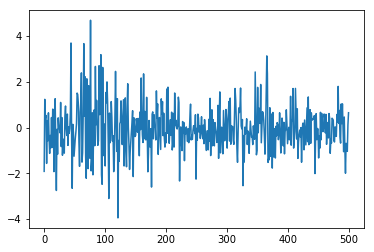

In [5]:
data = pd.read_csv('..\\base_material\\seOMXlogreturns2012to2014.csv', 
                   header=None, names=['logreturn'])
y = data.logreturn.values

fig, ax = plt.subplots()
ax.plot(y)

### a) Likelihood estimation for different values of $\beta$

Consider fixed values for $\phi = 0.98$ and $\sigma = 0.16$. $\beta$ is allowed to vary between 0 and 2.

In [38]:
theta = [0.98, 0.16]

def likelihood_bootstrap_pf(N, y, beta=0.70, resample=True):
    # Cumulatively build up log-likelihood
    ll = 0.0
    # Initialisation
    samples = stats.norm.rvs(0, theta[1], N)
    weights = 1 / N * np.ones((N,))
    weights_normalized = weights
    
    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        if resample:
             # Randomly choose ancestors
            ancestors = np.random.choice(samples, size=N, 
                                         replace=True, p=weights_normalized)
        else:
            ancestors = samples
            
        # Propagate
        samples = stats.norm.rvs(0, 1, N) * theta[1] + theta[0] * ancestors
        
#         # Weight
#         weights = stats.norm.logpdf(y[t], loc=0, 
#                                     scale=(beta * np.exp(samples / 2)))
#         # Subtract the max
#         weights = weights - np.max(weights)
#         # Update log-likelihood
#         ll += np.max(weights) + np.log(np.sum(np.exp(weights))) - np.log(N)
        
#         # Normalize weights to be probabilities
#         weights_normalized = np.exp(weights) / np.sum(np.exp(weights))

        # Weight
        weights = stats.norm.pdf(y[t], loc=0, 
                                 scale=(beta * np.exp(samples / 2)))
        # Update log-likelihood
        ll += np.log(np.sum(weights)) - np.log(N)
        
        # Normalize weights to be probabilities
        weights_normalized = weights / np.sum(weights)
        
    return ll

Run the bootstrap particle filter to estimate the log-likelihood.

In [42]:
def simulate(N=500, T=500, resample=True):
    ll = []
    beta_count = len(np.arange(0.5, 2.25, 0.1))
    for beta in np.arange(0.5, 2.25, 0.1):
        for i in range(10):
            ll.append(likelihood_bootstrap_pf(N, y[:T], beta, resample))

    ll = np.transpose(np.reshape(ll, (beta_count, 10)))
    
    return ll

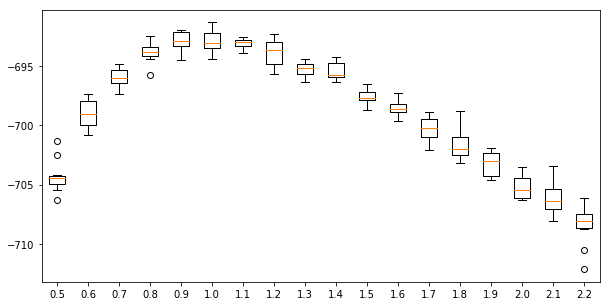

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(simulate(500, 500), labels=np.arange(0.5, 2.25, 0.1));

### b) Study how $N$ and $T$ affect the variance of the log-likelihood estimate

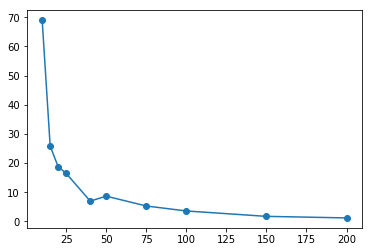

In [48]:
variances = []
ns = [10, 15, 20, 25, 40, 50, 75, 100, 150, 200]

for N in ns:
    lls = []
    for i in range(50):
        lls.append(likelihood_bootstrap_pf(N, y, beta=0.9))
    # Calculate variance
    variances.append(np.var(lls))
    
fig, ax = plt.subplots()
ax.plot(ns, variances, 'o-')

Variance reduces exponentially with growing $N$.

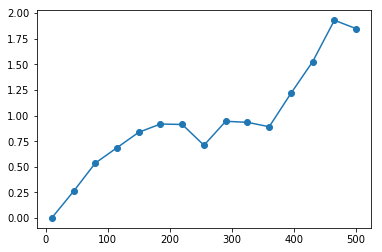

In [55]:
variances = []
ts = range(10, 501, 35)

for T in ts:
    lls = []
    for i in range(60):
        lls.append(likelihood_bootstrap_pf(200, y[:T], beta=0.9))
    # Calculate variance
    variances.append(np.var(lls))
    
fig, ax = plt.subplots()
ax.plot(ts, variances, 'o-')

Variance increases linearly with growing $T$.

### c) Study the influence of resampling on the variance of the estimator

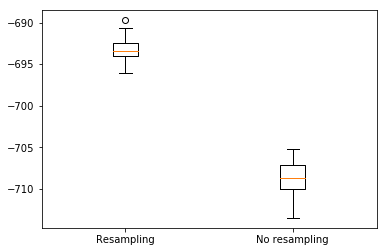

In [58]:
lls = np.zeros((60, 2))

# With resampling
for i in range(60):
    lls[i, 0] = likelihood_bootstrap_pf(200, y, beta=0.9)
    
# Without resampling
for i in range(60):
    lls[i, 1] = likelihood_bootstrap_pf(200, y, beta=0.9, resample=False)
    
fig, ax = plt.subplots()
ax.boxplot(lls, labels=['Resampling', 'No resampling']);

Without resampling the variance is larger and log-likelihood is generally lower.

## II.2 Fully adapted particle filter

### b) Implement the FAPF for model (ii) and compare the variance of the estimates of $\mathbb{E}(X_t\,|\,y_{1:t})$ to the estimates obtained by a bootstrap particle filter